# eICU data exploration

This code does some data exploring on the eICU dataset, focused on the hospital mortality.

Query results can be extracted like so:

```qr = get_query_result(user="dtank", database="eicu", query="SELECT count(*) FROM patient;")```

CSV files of certain data can be extracted like so:

```extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/noteTRY.csv", variablestring="patientUnitStayID, notePath, noteText", table="note")```

In [1]:
import pandas as pd
from pandas import option_context
import numpy as np
import matplotlib.pyplot as plt
# !pip install tableone
from tableone import TableOne, load_dataset
# !pip install icd9cms
from icd9cms.icd9 import search

from dataExtraction import get_query_result, extract_csv, get_df
from datavisualization import xmostcommon_doubleplot, xmostcommon_df

## Basic dataset characteristics

In [2]:
print("Number of patients in the dataset: ", 
      get_query_result(user="dtank", database="eicu", query="SELECT COUNT(DISTINCT uniquePid) FROM patient;")[0][0])
print("Number of admissions in the dataset: ",
     get_query_result(user="dtank", database="eicu", query="SELECT COUNT(*) FROM patient;")[0][0])
print("Number of hospitals in the dataset: ",
     get_query_result(user="dtank", database="eicu", query="SELECT COUNT(DISTINCT hospitalID) FROM patient;")[0][0])
print("Number of wards in the dataset: ",
     get_query_result(user="dtank", database="eicu", query="SELECT COUNT(DISTINCT wardID) FROM patient;")[0][0])
print("Number of admission diagnoses in the dataset: ",
     get_query_result(user="dtank", database="eicu", query="SELECT COUNT(DISTINCT apacheAdmissionDx) FROM patient;")[0][0])
print("Number of ICU units in the dataset: ",
     get_query_result(user="dtank", database="eicu", query="SELECT COUNT(DISTINCT unitType) FROM patient;")[0][0])
print("Years in the dataset: ",
     get_query_result(user="dtank", database="eicu", query="SELECT DISTINCT hospitalDischargeYear FROM patient;"))

# also include country, year, version of the dataset in the report

Number of patients in the dataset:  139367
Number of admissions in the dataset:  200859
Number of hospitals in the dataset:  208
Number of wards in the dataset:  335
Number of admission diagnoses in the dataset:  393
Number of ICU units in the dataset:  8
Years in the dataset:  [(2014,), (2015,)]


## Patient characteristics

In [3]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/patientCharacteristics.csv",
            variablestring="patientunitstayid, patienthealthsystemstayid, uniquePid, gender, age, ethnicity, admissionHeight, hospitalDischargeStatus, unitType, admissionWeight, unitDischargeStatus", 
            table="patient")

COPY 200859
data extracted


### Patient characteristics statistics table
We extract and preprocess the data, then use the [tableone](https://pypi.org/project/tableone/) package to make a patient characteristics table for both hospital and ICU mortality. 

In [4]:
patientChar = pd.read_csv("/home/dtank/data/volume_2/eicu_csv/patientCharacteristics.csv")

patientChar['age'] = patientChar['age'].replace("> 89", "89") # replace all > 89 with 89 entries 
patientChar['age'] = patientChar['age'].astype('float') # convert age from strings to floats

# renaming conventions
patientChar['gender'] = patientChar['gender'].replace("Other", "Other/Unknown") 
patientChar['gender'] = patientChar['gender'].replace("Unknown", "Other/Unknown") 

patientChar['hospitaldischargestatus'] = patientChar['hospitaldischargestatus'].replace('Alive', 'Alive at hospital discharge')
patientChar['hospitaldischargestatus'] = patientChar['hospitaldischargestatus'].replace('Expired', 'Dead at hospital discharge')

patientChar['unitdischargestatus'] = patientChar['unitdischargestatus'].replace('Alive', 'Alive at ICU discharge')
patientChar['unitdischargestatus'] = patientChar['unitdischargestatus'].replace('Expired', 'Dead at ICU discharge')

# only for unique patients
patientChar = patientChar.drop_duplicates(subset='uniquepid')


# variables for the tableone package
columns = ['gender', 'age', 'ethnicity', 'admissionheight', 'admissionweight', 'unittype']
categorical = ['gender', 'ethnicity', 'unittype']
labels = {'gender' : 'Gender', 
          'age' : 'Age', 
          'ethnicity' : 'Ethnicity', 
          'admissionheight' : 'Height', 
          'admissionweight' : 'Weight', 
          'unittype' : 'ICU Unit'}

patientCharTableHospital = TableOne(patientChar, columns=columns, categorical=categorical, rename=labels, 
                                    label_suffix=True, nonnormal=['age'], groupby='hospitaldischargestatus', pval=True)

In [5]:
patientCharTableHospital
# print(patientCharTableHospital.tabulate(tablefmt = 'latex')) # print a latex formatted table

Grouped by hospitaldischargestatus                                                                                 
                                                                Missing           Overall Alive at hospital discharge Dead at hospital discharge P-Value
n                                                                                  139367                      124981                      13129        
Gender, n (%)       Female                                          111      64038 (46.0)                57289 (45.9)                6144 (46.8)  <0.001
                    Male                                                     75176 (54.0)                67579 (54.1)                6963 (53.1)        
                    Other/Unknown                                                42 (0.0)                    26 (0.0)                   16 (0.1)        
Age, median [Q1,Q3]                                                  82  65.0 [53.0,77.0]            64.0 [52.0,76.0]           72.0 [61.0,82.0]  <0.001
Ethnicity, n (%)    African American                               1780      14672 (10.7)                13255 (10.7)                1303 (10.1)   0.141
                    Asian                                                      2338 (1.7)                  2073 (1.7)                  232 (1.8)        
                    Caucasian                                               107724 (78.3)                96567 (78.3)               10198 (78.7)        
                    Hispanic                                                   5233 (3.8)                  4685 (3.8)                  523 (4.0)        
                    Native American                                             964 (0.7)                   871 (0.7)                   87 (0.7)        
                    Other/Unknown                                              6656 (4.8)                  5945 (4.8)                  621 (4.8)        
Height, mean (SD)                                                  3153      169.3 (13.9)                169.4 (13.8)               168.3 (14.6)  <0.001
Weight, mean (SD)                                                  8170       83.9 (26.9)                 84.2 (26.7)                80.7 (28.1)  <0.001
ICU Unit, n (%)     CCU-CTICU                                         0       11404 (8.2)                 10386 (8.3)                  979 (7.5)  <0.001
                    CSICU                                                      5164 (3.7)                  4821 (3.9)                  305 (2.3)        
                    CTICU                                                      4597 (3.3)                  4302 (3.4)                  261 (2.0)        
                    Cardiac ICU                                                9362 (6.7)                  8243 (6.6)                 1026 (7.8)        
                    MICU                                                      11721 (8.4)                 10093 (8.1)                1546 (11.8)        
                    Med-Surg ICU                                             77928 (55.9)                69767 (55.8)                7359 (56.1)        
                    Neuro ICU                                                 10678 (7.7)                  9641 (7.7)                  916 (7.0)        
                    SICU                                                       8513 (6.1)                  7728 (6.2)                  737 (5.6)        
[1] Chi-squared tests for the following variables may be invalid due to the low number of observations: gender.

### Patient characteristics: mortality per ethnicity and age plot
We preprocess the patient characteristics data, extract the amount of deaths per ethnicity and age group, divide these by their total ethnicity amount (ethnicity normalized) to get the ethnicity normalized mortality rate per 1000 people. 

In [6]:
patientCharPlot = pd.read_csv("/home/dtank/data/volume_2/eicu_csv/patientCharacteristics.csv")
patientCharPlot = patientCharPlot.drop_duplicates(subset='uniquepid') # only for unique patients

# make age categories
patientCharPlot['age'] = patientCharPlot['age'].replace(dict.fromkeys([str(x) for x in list(range(0, 20))], '0-20'))
patientCharPlot['age'] = patientCharPlot['age'].replace(dict.fromkeys([str(x) for x in list(range(20, 30))], '20-30'))
patientCharPlot['age'] = patientCharPlot['age'].replace(dict.fromkeys([str(x) for x in list(range(30, 40))], '30-40'))
patientCharPlot['age'] = patientCharPlot['age'].replace(dict.fromkeys([str(x) for x in list(range(40, 50))], '40-50'))
patientCharPlot['age'] = patientCharPlot['age'].replace(dict.fromkeys([str(x) for x in list(range(50, 60))], '50-60'))
patientCharPlot['age'] = patientCharPlot['age'].replace(dict.fromkeys([str(x) for x in list(range(60, 70))], '60-70'))
patientCharPlot['age'] = patientCharPlot['age'].replace(dict.fromkeys([str(x) for x in list(range(70, 80))], '70-80'))
lastcat = [str(x) for x in list(range(80, 90))]
lastcat.append('> 89')
patientCharPlot['age'] = patientCharPlot['age'].replace(dict.fromkeys(lastcat, '80+'))

# group by ethnicity and age and find the value counts
mortEthAge = patientCharPlot.groupby(['ethnicity', 'age'], as_index=False).hospitaldischargestatus.value_counts()
mortEthAge = mortEthAge[mortEthAge['hospitaldischargestatus'] == 'Expired']

# find the total amount per ethnicity category for normalization purposes
AfAmTotal = len(patientChar[patientChar['ethnicity'] == 'African American']['ethnicity'])
AsianTotal = len(patientChar[patientChar['ethnicity'] == 'Asian']['ethnicity'])
CaucasTotal = len(patientChar[patientChar['ethnicity'] == 'Caucasian']['ethnicity'])
NatAmTotal = len(patientChar[patientChar['ethnicity'] == 'Native American']['ethnicity'])
UnknTotal = len(patientChar[patientChar['ethnicity'] == 'Other/Unknown']['ethnicity'])

# find the normalized values for the bar plot
AfAm = (mortEthAge[mortEthAge['ethnicity'] == 'African American']['count']/AfAmTotal*1000).to_list()
Asian = (mortEthAge[mortEthAge['ethnicity'] == 'Asian']['count']/AsianTotal*1000).to_list()
Caucas = (mortEthAge[mortEthAge['ethnicity'] == 'Caucasian']['count']/CaucasTotal*1000).to_list()
NatAm = (mortEthAge[mortEthAge['ethnicity'] == 'Native American']['count']/NatAmTotal*1000).to_list()
Unkn = (mortEthAge[mortEthAge['ethnicity'] == 'Other/Unknown']['count']/UnknTotal*1000).to_list()

Make a plot for all ethnicities and ages, for their normalized hospital mortality per 1000 people.

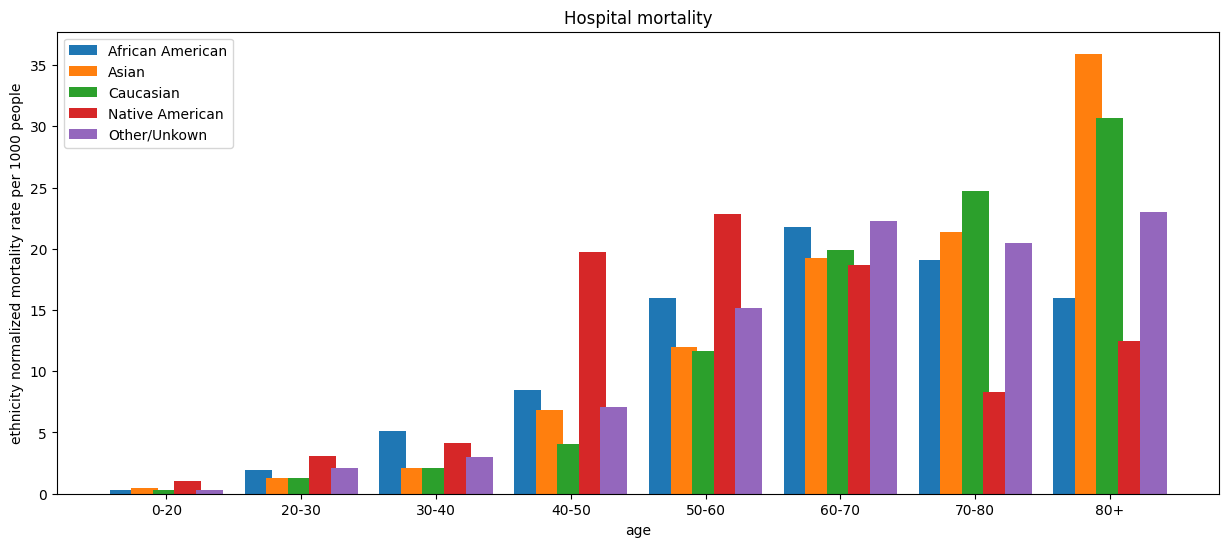

In [7]:
X = np.arange(8)
fig = plt.figure(figsize=(15,6))
margin = 0.8
plt.bar(X + -0.4 * margin, AfAm, width = 0.2)
plt.bar(X + -0.2 * margin, Asian, width = 0.2)
plt.bar(X , Caucas, width = 0.2)
plt.bar(X + 0.2 * margin, NatAm, width = 0.2)
plt.bar(X + 0.4 * margin, Unkn, width = 0.2)
plt.xlabel('age')
plt.ylabel('ethnicity normalized mortality rate per 1000 people')
plt.legend(labels=['African American', 'Asian', 'Caucasian', 'Native American', 'Other/Unkown'])
plt.xticks((0, 1, 2, 3, 4, 5, 6, 7), ('0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80+'))
plt.title('Hospital mortality')

plt.show()

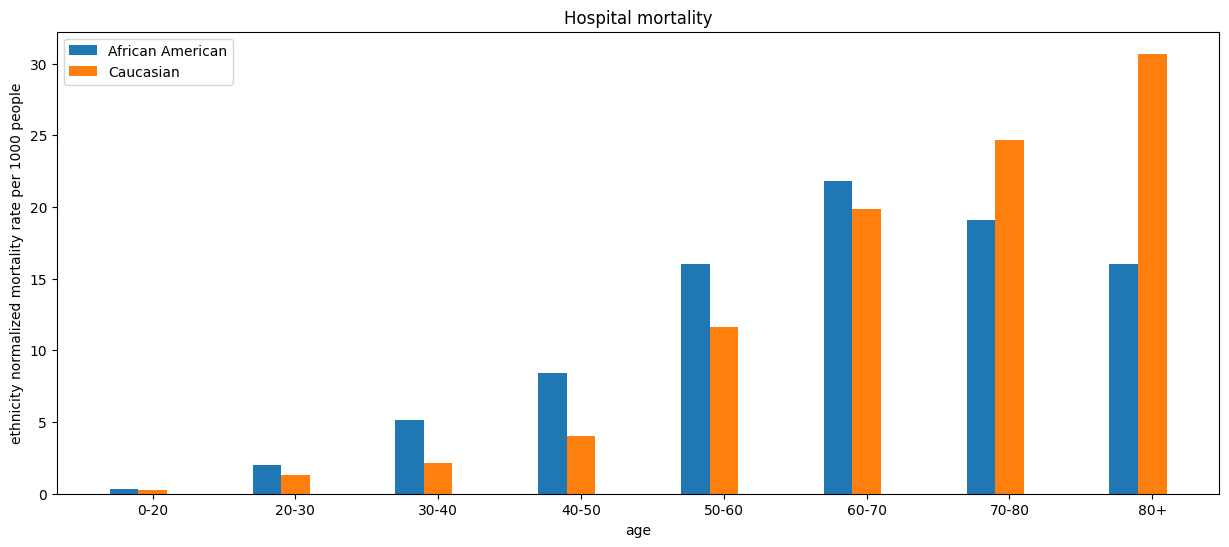

In [8]:
X = np.arange(8)
fig = plt.figure(figsize=(15,6))
margin = 0.8
plt.bar(X + -0.2, AfAm, width = 0.2)
plt.bar(X , Caucas, width = 0.2)
plt.xlabel('age')
plt.ylabel('ethnicity normalized mortality rate per 1000 people')
plt.legend(labels=['African American', 'Caucasian'])
plt.xticks((0, 1, 2, 3, 4, 5, 6, 7), ('0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80+'))
plt.title('Hospital mortality')

plt.show()

### Patient characteristics: frequency of hospital visits plot
We preprocess the data, find the sum of the amount of hospital visits and plot it.

In [10]:
PatientCharPatVis = pd.read_csv("/home/dtank/data/volume_2/eicu_csv/patientCharacteristics.csv")
numuniquepats = len(np.unique(PatientCharPatVis['uniquepid'])) # find the number of unique patients
visitAmount = PatientCharPatVis.uniquepid.value_counts() # find the amount of visists per unique patient
visitAmount = visitAmount.value_counts().rename_axis('visit_amount').reset_index(name='counts') # find the occurence of every visit amount
visitAmount['percentage'] = visitAmount['counts']/numuniquepats * 100 # turn that into a percentage
percentage5 = visitAmount[4:]['percentage'].sum() # sum the percentage from 5+ visits
counts5 = visitAmount[4:]['counts'].sum() # sum the counts from 5+ visits
visitAmount = visitAmount.iloc[:4] # shorten the dataframe to 4 rows
visitAmount.loc[len(visitAmount.index)] = [5, counts5, percentage5] # add the last row for 5+ visits
visitAmount['percentage'] = visitAmount['percentage'].round().astype('int') # round the percentages
visitAmount['visit_amount'] = visitAmount['visit_amount'].astype('int') # turn the visit amounts to int

Make a pie chart of the frequency of hospital visits.

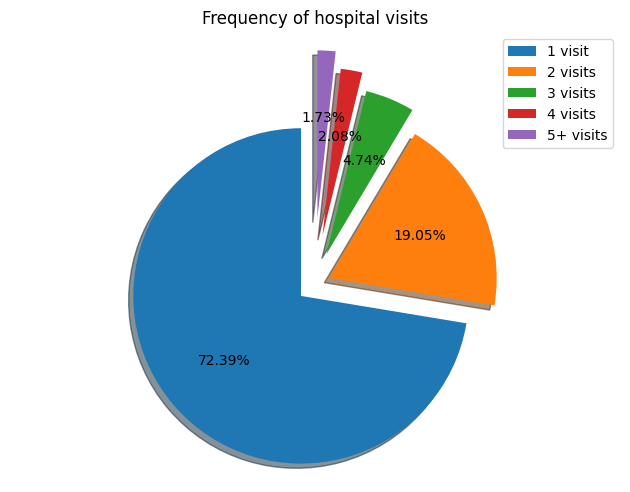

In [11]:
labels= ['1 visit', '2 visits', '3 visits', '4 visits', '5+ visits']
sizes= visitAmount['counts']
plt.pie(sizes, startangle=90, shadow=True,explode=(0.1, 0.1, 0.2, 0.3, 0.4), autopct='%1.2f%%')
plt.axis('equal')
plt.legend(labels)
plt.tight_layout()
plt.title('Frequency of hospital visits')

plt.show()

### Patient characteristics: LoS

In [56]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/LoS.csv", variablestring="patient.patientUnitStayID, patient.uniquePID, patient.hospitalDischargeStatus, patient.unitDischargeStatus, apachepatientresult.actualiculos, apachepatientresult.actualhospitallos", table="patient, apachepatientresult")

COPY 297064
data extracted


In [58]:
los = pd.read_csv('/home/dtank/data/volume_2/eicu_csv/LoS.csv')
los.groupby('hospitaldischargestatus')['actualhospitallos'].mean()

hospitaldischargestatus
Alive      7.995669
Expired    8.629649
Name: actualhospitallos, dtype: float64

## (Admission) Diagnoses

In [12]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/diagnoses.csv", variablestring="patient.patientUnitStayID, patient.uniquePID, patient.apacheAdmissionDx, patient.hospitalDischargeStatus, patient.unitDischargeStatus, diagnosis.diagnosisString, diagnosis.ICD9Code", table="patient, diagnosis")

COPY 2710672
data extracted


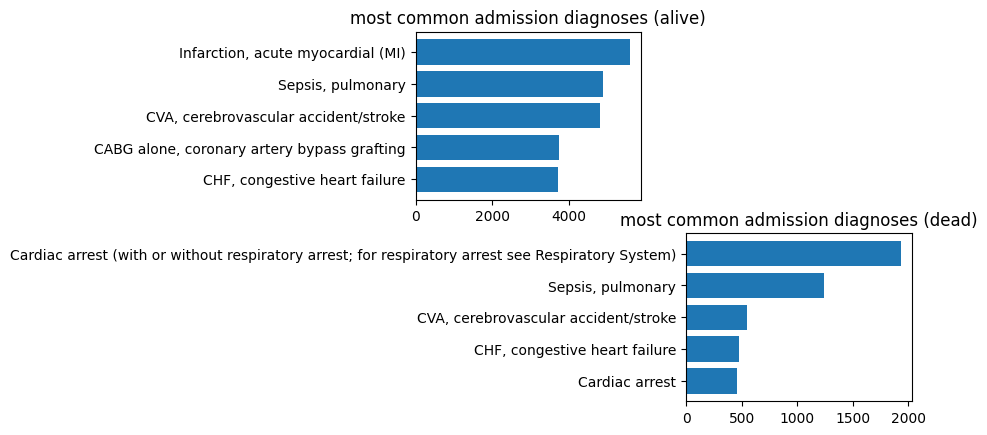

In [13]:
diagnoses = pd.read_csv("/home/dtank/data/volume_2/eicu_csv/diagnoses.csv")
diagnoses = diagnoses.drop_duplicates(subset='uniquepid') # get unique patients
diagnoses['icd9code'] = diagnoses['icd9code'].str.split(',').str[0] # get only the first icd9 code

# most common admission diagnoses
admdiag = diagnoses.groupby('hospitaldischargestatus', as_index=False)['apacheadmissiondx'].value_counts().reset_index(drop=True)
admdiag_alive = admdiag[admdiag['hospitaldischargestatus'] == 'Alive'][:5].sort_values('count', ascending=True)
admdiag_dead = admdiag[admdiag['hospitaldischargestatus'] == 'Expired'][:5].sort_values('count', ascending=True)

# plot most common admission diagnoses
xmostcommon_doubleplot(admdiag_alive, admdiag_dead, 'apacheadmissiondx', "most common admission diagnoses")

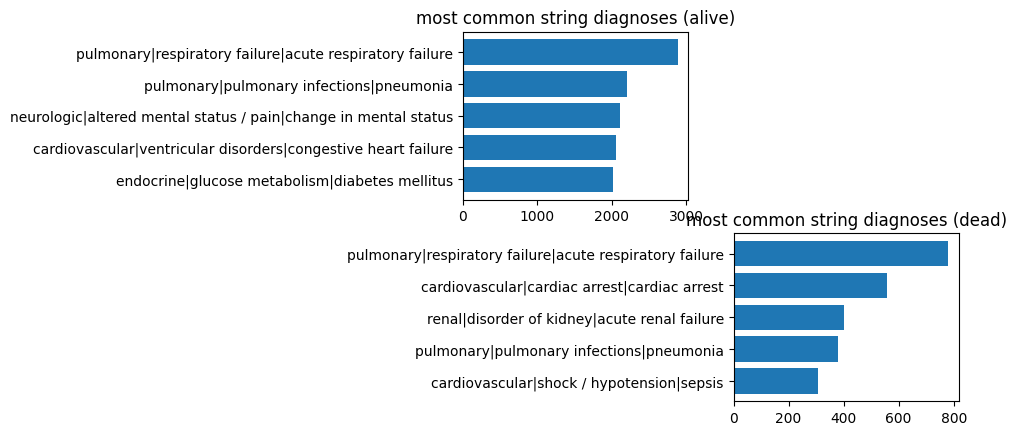

In [14]:
# most common diagnosis strings
diagstring = diagnoses.groupby('hospitaldischargestatus', as_index=False)['diagnosisstring'].value_counts().reset_index(drop=True)
diagstring_alive = diagstring[diagstring['hospitaldischargestatus'] == 'Alive'][:5].sort_values('count', ascending=True)
diagstring_dead = diagstring[diagstring['hospitaldischargestatus'] == 'Expired'][:5].sort_values('count', ascending=True)

# plot the most common diagnosis strings
xmostcommon_doubleplot(diagstring_alive, diagstring_dead, 'diagnosisstring', "most common string diagnoses")

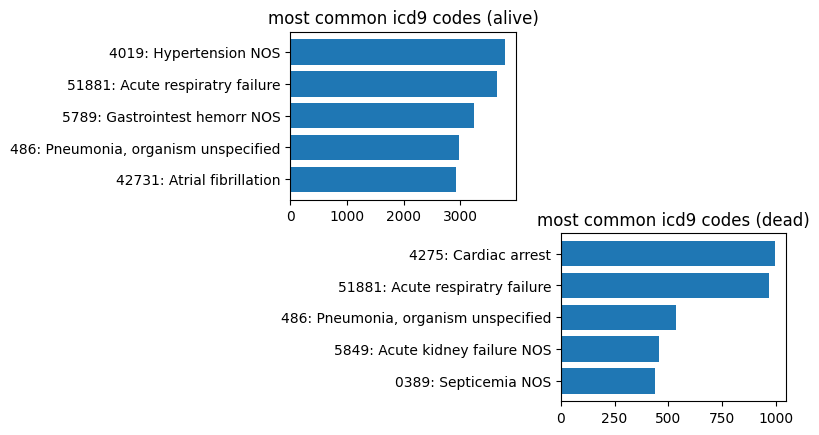

In [15]:
# helper function to convert icd9 code to string
def code_to_string(x):
    try: 
        codeandtext = str(search(x)).split(":")[0:2]
        return codeandtext[0] + ": " + codeandtext[1]
    except:
        return 'None'

# most common icd9 code diagnosis
icd9code = diagnoses.groupby('hospitaldischargestatus', as_index=False)['icd9code'].value_counts().reset_index(drop=True)
icd9code_alive = icd9code[icd9code['hospitaldischargestatus'] == 'Alive'][:5].sort_values('count', ascending=True)
icd9code_dead = icd9code[icd9code['hospitaldischargestatus'] == 'Expired'][:5].sort_values('count', ascending=True)
icd9code_alive['icd9codetostring'] = icd9code['icd9code'].apply(code_to_string)
icd9code_dead['icd9codetostring'] = icd9code['icd9code'].apply(code_to_string)

xmostcommon_doubleplot(icd9code_alive, icd9code_dead, 'icd9codetostring', "most common icd9 codes")

## Hospital information

In [16]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/hospital.csv", variablestring="patient.hospitalID, patient.uniquePID, patient.hospitalDischargeStatus, patient.unitDischargeStatus, hospital.teachingstatus, hospital.region", table="patient, hospital", joinon='hospitalID')

COPY 200859
data extracted


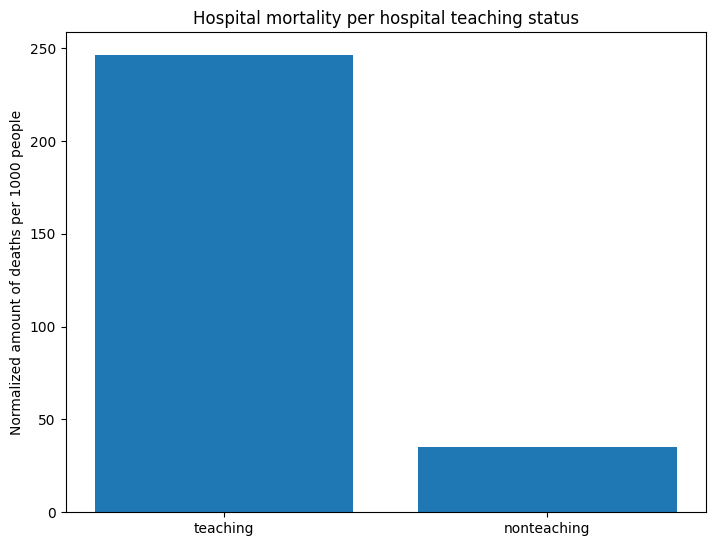

In [17]:
hospital = pd.read_csv("/home/dtank/data/volume_2/eicu_csv/hospital.csv")

# find the amount of dead patients per hospital status
hospital_teachingstatus = hospital.groupby(['teachingstatus'], as_index=False).hospitaldischargestatus.value_counts()
hospital_teachingstatus = hospital_teachingstatus[hospital_teachingstatus['hospitaldischargestatus']=='Expired']

# find the total amount of patients per hospital status
total_nonteaching = (hospital['teachingstatus']=='f').sum()
total_teaching = (hospital['teachingstatus']=='t').sum()

# calculate the mortality per 1000 people per hospital status
mortality_teaching = hospital_teachingstatus['count'][1]/total_teaching*1000
mortality_nonteaching = hospital_teachingstatus['count'][3]/total_nonteaching*1000

# make the plot
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
teachingstatus = ['teaching', 'nonteaching']
norm_mort = [mortality_teaching, mortality_nonteaching]
ax.bar(teachingstatus, norm_mort)
ax.set_ylabel('Normalized amount of deaths per 1000 people')
plt.title('Hospital mortality per hospital teaching status')
plt.show()

Analyze raportation bias: teaching hospital might get more difficult cases?

In [18]:
import os
query = f"""\\COPY (SELECT patient.hospitalID, patient.uniquePID, patient.hospitalDischargeStatus, patient.unitDischargeStatus, 
                           hospital.teachingstatus, hospital.region,
                           apachepatientresult.apachescore
                    FROM patient
                    JOIN hospital 
                    ON patient.hospitalid = hospital.hospitalid
                    JOIN apachepatientresult
                    ON patient.patientunitstayid = apachepatientresult.patientunitstayid)
                    TO '/home/dtank/data/volume_2/eicu_csv/apachehospital.csv' WITH CSV HEADER; """
os.system(f'psql eicu -c "{query}"')

COPY 297064


0

In [19]:
apachehospital = pd.read_csv('/home/dtank/data/volume_2/eicu_csv/apachehospital.csv')
apachehospital.groupby('teachingstatus').apachescore.mean()

teachingstatus
f    54.349575
t    55.967498
Name: apachescore, dtype: float64

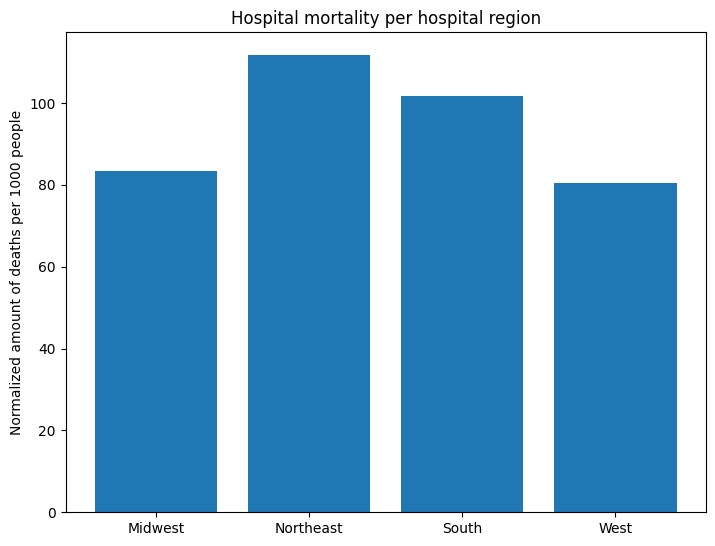

In [20]:
# gather data filtered on hospital region and amount of deaths
hospital_region = hospital.groupby(['region'], as_index=False).hospitaldischargestatus.value_counts()
hospital_region = hospital_region[hospital_region['hospitaldischargestatus']=='Expired']

# find total of patients per region
total_midwest = (hospital['region']=='Midwest').sum()
total_northeast = (hospital['region']=='Northeast').sum()
total_south = (hospital['region']=='South').sum()
total_west = (hospital['region']=='West').sum()

# calculate the normalized amount of deaths per region
mortality_midwest = hospital_region['count'][1]/total_midwest*1000
mortality_northeast = hospital_region['count'][3]/total_northeast*1000
mortality_south = hospital_region['count'][5]/total_south*1000
mortality_west = hospital_region['count'][7]/total_west*1000

# make the plot
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
region = hospital_region['region']
norm_mort = [mortality_midwest, mortality_northeast, mortality_south, mortality_west]
ax.bar(region, norm_mort)
ax.set_ylabel('Normalized amount of deaths per 1000 people')
plt.title("Hospital mortality per hospital region")
plt.show()

## Past History

In [21]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/pastHistory.csv", variablestring="patient.patientUnitStayID, patient.uniquePID, patient.hospitalDischargeStatus, patient.unitDischargeStatus, pastHistory.pasthistoryvaluetext", table="patient, pasthistory")

COPY 1149180
data extracted


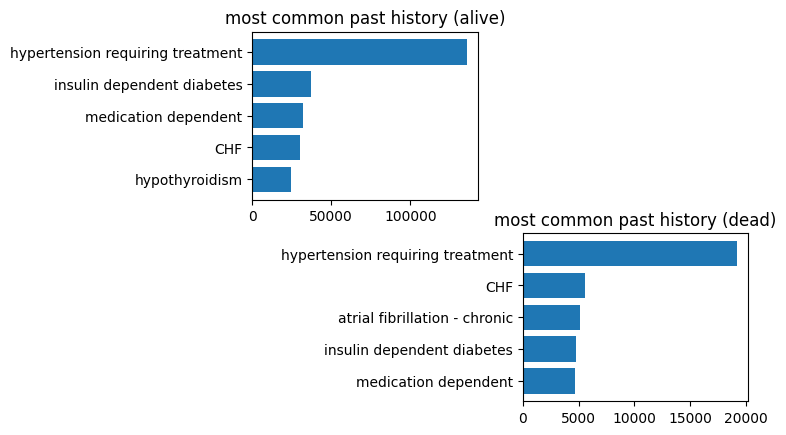

In [22]:
pastHistory = pd.read_csv('/home/dtank/data/volume_2/eicu_csv/pastHistory.csv')
pastHistory = pastHistory[pastHistory.pasthistoryvaluetext != 'Performed'] # remove the 'performed' value rows since it does not give insightful information

# find the most common past history for alive and expired patients
pasthist = pastHistory.groupby('hospitaldischargestatus', as_index=False)['pasthistoryvaluetext'].value_counts().reset_index(drop=True)
pasthist_alive = pasthist[pasthist['hospitaldischargestatus'] == 'Alive'][:5].sort_values('count', ascending=True)
pasthist_dead = pasthist[pasthist['hospitaldischargestatus'] == 'Expired'][:5].sort_values('count', ascending=True)

# make the plot
xmostcommon_doubleplot(pasthist_alive, pasthist_dead, 'pasthistoryvaluetext', 'most common past history')

## Treatment

In [23]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/treatment.csv", variablestring="patient.patientUnitStayID, patient.uniquePID, patient.hospitalDischargeStatus, patient.unitDischargeStatus, treatment.treatmentstring", table="patient, treatment")

COPY 3688745
data extracted


In [24]:
treatment = pd.read_csv('/home/dtank/data/volume_2/eicu_csv/treatment.csv')
treatment['treatmentvalue'] = treatment['treatmentstring'].str.split('|').str[-1] # take only the treatment value (last one in treatment path)

# show the top 20 treatment amounts per patient
treatmentAmount = treatment.uniquepid.value_counts()
treatmentAmount = treatmentAmount.value_counts().rename_axis('treatment_amount').reset_index(name='counts')
treatmentAmount[:20]

,treatment_amount,counts
0,1,13830
1,2,11791
2,3,9475
3,4,7993
4,5,6347
5,6,5472
6,7,4475
7,8,4003
8,9,3319
9,10,3012


In [25]:
print('maximum treatment amounts:', treatmentAmount['treatment_amount'].max())

maximum treatment amounts: 8123


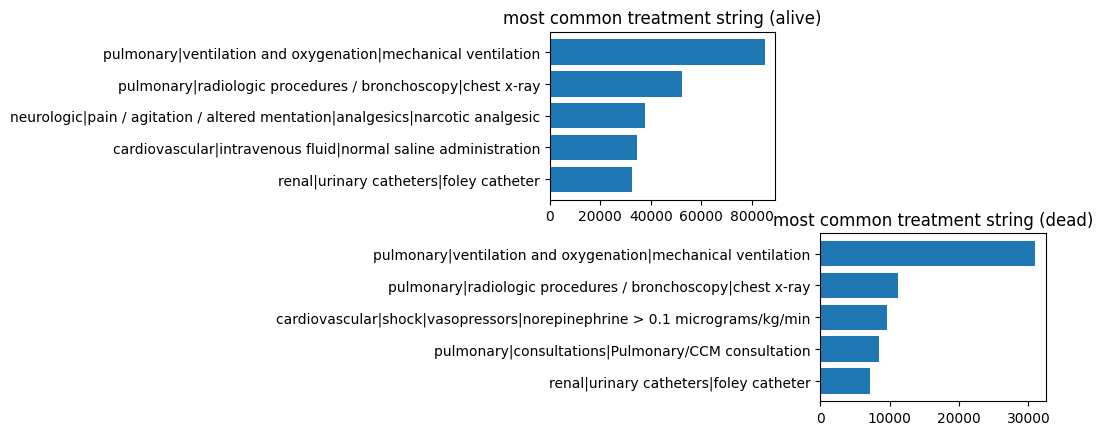

In [26]:
treatmentstring = treatment.groupby('hospitaldischargestatus', as_index=False)['treatmentstring'].value_counts().reset_index(drop=True)
treatmentstring_alive = treatmentstring[treatmentstring['hospitaldischargestatus'] == 'Alive'][:5].sort_values('count', ascending=True)
treatmentstring_dead = treatmentstring[treatmentstring['hospitaldischargestatus'] == 'Expired'][:5].sort_values('count', ascending=True)

# make the plot
xmostcommon_doubleplot(treatmentstring_alive, treatmentstring_dead, 'treatmentstring', 'most common treatment string')

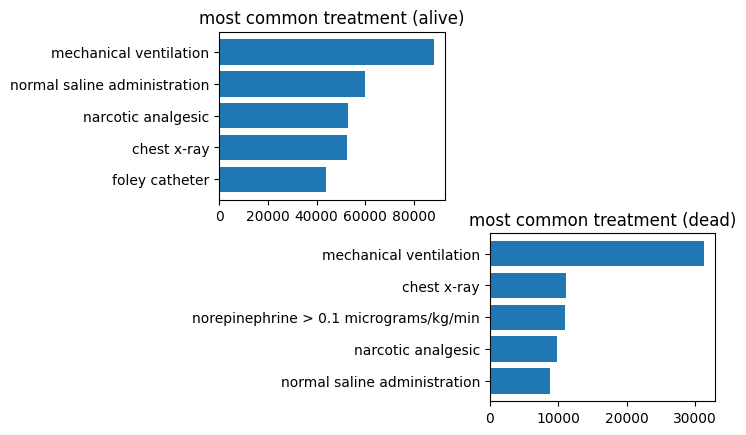

In [27]:
treatmentvalue = treatment.groupby('hospitaldischargestatus', as_index=False)['treatmentvalue'].value_counts().reset_index(drop=True)
treatmentvalue_alive = treatmentvalue[treatmentvalue['hospitaldischargestatus'] == 'Alive'][:5].sort_values('count', ascending=True)
treatmentvalue_dead = treatmentvalue[treatmentvalue['hospitaldischargestatus'] == 'Expired'][:5].sort_values('count', ascending=True)

xmostcommon_doubleplot(treatmentvalue_alive, treatmentvalue_dead, 'treatmentvalue', 'most common treatment')

## Predicted and actual mortality

In [28]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/apachepatientresult.csv", variablestring="apachescore, predictedicumortality, actualicumortality, predictedhospitalmortality, actualhospitalmortality", table="apachepatientresult")

COPY 297064
data extracted


In [29]:
apachepatientresult = pd.read_csv("/home/dtank/data/volume_2/eicu_csv/apachepatientresult.csv")
hospitalmortality_apache = apachepatientresult.groupby('actualhospitalmortality')['apachescore'].mean()
hospitalmortality_mortality = apachepatientresult.groupby('actualhospitalmortality')['predictedhospitalmortality'].mean()

print(hospitalmortality_apache)
print()
print(hospitalmortality_mortality)

actualhospitalmortality
ALIVE      51.530346
EXPIRED    86.843852
Name: apachescore, dtype: float64

actualhospitalmortality
ALIVE      0.012055
EXPIRED    0.224232
Name: predictedhospitalmortality, dtype: float64


## Admission drugs

In [30]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/admissiondrugs.csv", variablestring="patient.patientUnitStayID, patient.uniquePID, patient.hospitalDischargeStatus, patient.unitDischargeStatus, admissionDrug.drugname, admissionDrug.drughiclseqno", table="patient, admissiondrug")

COPY 874920
data extracted


In [34]:
admissiondrug = pd.read_csv("/home/dtank/data/volume_2/eicu_csv/admissiondrugs.csv")
admissiondrug['codeanddrug'] = admissiondrug['drughiclseqno'].astype('string') + ': ' + admissiondrug['drugname'] # show both drug code and drug name in the same column

In [32]:
print('avg amount of admission drugs registered:', admissiondrug['uniquepid'].value_counts().mean())
print('maximum amount of admission drugs registered: ', admissiondrug['uniquepid'].value_counts().max())
print('minimum amount of admission drugs registered: ', admissiondrug['uniquepid'].value_counts().min())

avg amount of admission drugs registered: 27.584336969544108
maximum amount of admission drugs registered:  11671
minimum amount of admission drugs registered:  1


In [33]:
# find the most common drugs given to expired patients
xmostcommon_df(admissiondrug, 'hospitaldischargestatus', 'codeanddrug', 10)

,codeanddrug,count
4576,1326: COLACE,1225
4575,8831: GABAPENTIN,1330
4574,2879: PREDNISONE,1377
4573,2074: ALBUTEROL,1397
4572,1794: ASPIRIN,1509
4571,2849: LEVOTHYROXINE SODIUM,1630
4570,4673: OMEPRAZOLE,2045
4569,1820: ASPIRIN,2103
4568,132: LISINOPRIL,2332
4567,3660: LASIX,2571


## Active medication

In [35]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/medication.csv", variablestring="patient.patientUnitStayID, patient.uniquePID, patient.hospitalDischargeStatus, patient.unitDischargeStatus, medication.drugname, medication.drughiclseqno", table="patient, medication")

COPY 7301853
data extracted


In [36]:
medication = pd.read_csv("/home/dtank/data/volume_2/eicu_csv/medication.csv")

# # show both drug code and drug name in the same column and skip nans
medication['codeandmed'] = medication['drughiclseqno'].astype('string') + ': ' + medication['drugname']
medication = medication.dropna()

In [37]:
print('avg amount of active medication per patient:', medication['uniquepid'].value_counts().mean())
print('maximum amount of active medication per patient: ', medication['uniquepid'].value_counts().max())
print('minimum amount of active medication per patient: ', medication['uniquepid'].value_counts().min())

avg amount of active medication per patient: 38.739252260909396
maximum amount of active medication per patient:  1153
minimum amount of active medication per patient:  1


In [38]:
# find the most common drugs given to expired patients
xmostcommon_df(medication, 'hospitaldischargestatus', 'codeandmed', 10)

,codeandmed,count
1777,4846.0: LORAZEPAM,2388
1776,8255.0: SODIUM CHLORIDE 0.9 % IV : 1000 ML,2436
1775,1619.0: MIDAZOLAM,2569
1774,8255.0: 1000 ML - SODIUM CHLORIDE 0.9 % IV SOLN,2657
1773,25386.0: fentaNYL citrate (PF),2671
1772,1866.0: ACETAMINOPHEN,3116
1771,8255.0: NaCl 0.9% MBP,3164
1770,3660.0: FUROSEMIDE,3538
1769,8255.0: SODIUM CHLORIDE 0.9%,3967
1768,8255.0: 1000 ML FLEX CONT : SODIUM CHLORIDE 0.9 % IV SOLN,4872


## Lab tests

In [39]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/lab.csv", variablestring="patient.patientUnitStayID, patient.uniquePID, patient.hospitalDischargeStatus, patient.unitDischargeStatus, lab.labname", table="patient, lab")

COPY 39132531
data extracted


In [40]:
lab = pd.read_csv("/home/dtank/data/volume_2/eicu_csv/lab.csv")

In [41]:
print('avg amount of ordered lab tests per patient:', lab['uniquepid'].value_counts().mean())
print('maximum amount of ordered lab tests per patient: ', lab['uniquepid'].value_counts().max())
print('minimum amount of ordered lab tests per patient: ', lab['uniquepid'].value_counts().min())

avg amount of ordered lab tests per patient: 283.0583295358375
maximum amount of ordered lab tests per patient:  11933
minimum amount of ordered lab tests per patient:  1


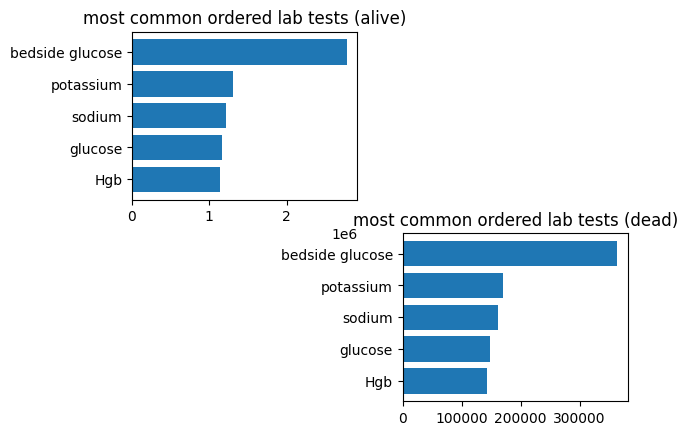

In [42]:
labtest = lab.groupby('hospitaldischargestatus', as_index=False)['labname'].value_counts().reset_index(drop=True)
labtest_alive = labtest[labtest['hospitaldischargestatus'] == 'Alive'][:5].sort_values('count', ascending=True)
labtest_dead = labtest[labtest['hospitaldischargestatus'] == 'Expired'][:5].sort_values('count', ascending=True)

xmostcommon_doubleplot(labtest_alive, labtest_dead, 'labname', 'most common ordered lab tests')

## Notes

In [43]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/basicnotes.csv", variablestring="patient.patientUnitStayID, patient.uniquePID, patient.hospitalDischargeStatus, patient.unitDischargeStatus, note.notepath, note.notetext", table="patient, note")

COPY 2254179
data extracted


In [44]:
basicnotes = pd.read_csv('/home/dtank/data/volume_2/eicu_csv/basicnotes.csv')

In [45]:
print('avg amount of notes per patient:', basicnotes['uniquepid'].value_counts().mean())
print('maximum amount of notes per patient: ', basicnotes['uniquepid'].value_counts().max())
print('minimum amount of notes per patient: ', basicnotes['uniquepid'].value_counts().min())

avg amount of notes per patient: 16.43239125522128
maximum amount of notes per patient:  2698
minimum amount of notes per patient:  1


In [46]:
print('average amount of notes for dead patients: ', basicnotes.groupby('hospitaldischargestatus')['uniquepid'].value_counts()['Expired'].mean())
print('average amount of notes for alive patients: ', basicnotes.groupby('hospitaldischargestatus')['uniquepid'].value_counts()['Alive'].mean())

average amount of notes for dead patients:  21.16424377970366
average amount of notes for alive patients:  15.537433305703319


In [47]:
basicnotes['notetext'] = basicnotes['notetext'].replace(np.nan, '')
basicnotes['notelen'] = basicnotes['notetext'].apply(lambda x: len(x.split()))
print('average amount of note length: ', basicnotes['notelen'].mean(), ' words')

basicnotes['notepath'] = basicnotes['notepath'].replace(np.nan, '')
basicnotes['notepathlen'] = basicnotes['notepath'].apply(lambda x: len(x.split('/')))
print('average amount of note path length: ', basicnotes['notepathlen'].mean())

average amount of note length:  1.7967876552838085  words
average amount of note path length:  6.018635166062677


In [48]:
linkednotes = pd.read_csv("/home/dtank/data/volume_2/scispacyLinked/entityLinked-note-notepath.csv")
linkednotes = linkednotes.rename(columns = {'Unnamed: 0' : 'index', 'ID' : 'patientunitstayid'})

# joining the df's: no success
# joinedlinkednotes = linkednotes.join(basicnotes.set_index('patientunitstayid'), on='patientunitstayid')
# joinedlinkednotes = joinedlinkednotes.dropna(subset=['Extracted entities'])
# joinedlinkednotes

In [49]:
# avg amount of extracted entities per stay
linkednotes['numextractedentities'] = linkednotes['Extracted entities'].apply(lambda x: len(x.split(',')))
print('average amount of extracted entities per stay: ', linkednotes.groupby('patientunitstayid')['numextractedentities'].mean().mean(), ' entities')

# avg amount of extracted entity labels per stay
linkednotes['numextractedlabels'] = linkednotes['Entity labels'].apply(lambda x: len(x.split(',')))
print('average amount of extracted labels per stay: ', linkednotes.groupby('patientunitstayid')['numextractedlabels'].mean().mean(), ' labels')

# avg amount of CUIs per stay
linkednotes['numextractedcuis'] = linkednotes['CUIs'].apply(lambda x: len(x.split(',')))
print('average amount of extracted CUIs per stay: ', linkednotes.groupby('patientunitstayid')['numextractedcuis'].mean().mean(), ' CUIs')

# avg amount of UML linked entities per stay
linkednotes['numlinkedentities'] = linkednotes['UMLs linked entity names'].apply(lambda x: len(x.split(',')))
print('average amount of linked entities per stay: ', linkednotes.groupby('patientunitstayid')['numlinkedentities'].mean().mean(), ' linked entities')

average amount of extracted entities per stay:  1.5842947407683372  entities
average amount of extracted labels per stay:  1.5842947407683372  labels
average amount of extracted CUIs per stay:  1.5842947407683372  CUIs
average amount of linked entities per stay:  1.5855106183641723  linked entities


In [50]:
# top 10 most extracted entities
linkednotes['UMLs linked entity names'].value_counts()[:10]

['Hypersensitivity', 'Hypersensitivity']                454048
['Hypersensitivity']                                    266514
['ethanol']                                              38042
['Dyspnea', 'Dyspnea']                                   13160
['Coronary heart disease', 'Coronary heart disease']     11040
['Pain', 'Pain']                                          8646
['Pain', 'Fever']                                         8078
['Malignant Neoplasms', 'Malignant Neoplasms']            7538
['Chest Pain', 'Chest Pain']                              7136
['Abdominal Pain', 'Abdominal Pain']                      6844
Name: UMLs linked entity names, dtype: int64

In [51]:
basicnotes['notepath'].value_counts()[:10]

notes/Shared/View and Save/Save Options/Print/Copies/Copies                                                    479129
notes/Progress Notes/Assessment and Plan/View Options/System View                                              274138
notes/Progress Notes/Assessment and Plan/Include Rx/Include Rx                                                 170556
notes/Progress Notes/Admission Page One/Source of Patient Information:/Medical Records                         128637
notes/Progress Notes/Allergies / Preadmission Medications/Allergies/Yes                                        110190
notes/Progress Notes/Allergies / Preadmission Medications/Allergies/No                                         108914
notes/Progress Notes/Allergies / Preadmission Medications/Pre-Admission Medications/Yes                         98506
notes/Progress Notes/Allergies / Preadmission Medications/Pre-Admission Medications/Unknown                     80555
notes/Progress Notes/Social History / Family History/Soc

## Nurse assessment
* note this is only 30% of the data because of disc space shortages

In [52]:
nurseassessment = pd.read_csv('/home/dtank/data/volume_2/scispacyLinked/entityLinked-nurseAssessment.csv')
nurseassessment

,Unnamed: 0,ID,Full note,Extracted entities,Entity labels,CUIs,UMLs linked entity names
0,0,984597,"flowsheet, Flowsheet Cell Labels, Nursing Asse...",['frothy'],['DISEASE'],['C4523940'],['Foamy urine']
1,1,1005431,"flowsheet, Flowsheet Cell Labels, Nursing Asse...",['pain'],['DISEASE'],['C0030193'],['Pain']
2,2,1023060,"flowsheet, Flowsheet Cell Labels, Nursing Asse...","['Cough', 'Cough']","['DISEASE', 'DISEASE']","['C0010200', 'C0010200']","['Coughing', 'Coughing']"
3,3,1023060,"flowsheet, Flowsheet Cell Labels, Nursing Asse...","['Cough', 'Cough']","['DISEASE', 'DISEASE']","['C0010200', 'C0010200']","['Coughing', 'Coughing']"
4,4,1003035,"flowsheet, Flowsheet Cell Labels, Nursing Asse...","['Cough', 'Cough']","['DISEASE', 'DISEASE']","['C0010200', 'C0010200']","['Coughing', 'Coughing']"
...,...,...,...,...,...,...,...
1440348,1440348,1016390,"flowsheet, Flowsheet Cell Labels, Nursing Asse...","['Edema', 'Edema']","['DISEASE', 'DISEASE']","['C0013604', 'C0013604']","['Edema', 'Edema']"
1440349,1440349,1016390,"flowsheet, Flowsheet Cell Labels, Nursing Asse...","['Edema', 'Edema']","['DISEASE', 'DISEASE']","['C0013604', 'C0013604']","['Edema', 'Edema']"
1440350,1440350,1050746,"flowsheet, Flowsheet Cell Labels, Nursing Asse...",['systolic murmur'],['DISEASE'],['C0232257'],['Systolic Murmurs']
1440351,1440351,1045659,"flowsheet, Flowsheet Cell Labels, Nursing Asse...","['Cough', 'Cough']","['DISEASE', 'DISEASE']","['C0010200', 'C0010200']","['Coughing', 'Coughing']"


In [53]:
# top 10 most extracted entities
nurseassessment['UMLs linked entity names'].value_counts()[:10]

['Coughing', 'Coughing']    320667
['Sore to touch']           282959
['Falls']                   208995
['Falls', 'Falls']          167510
['Edema', 'Edema']          162564
['Edema']                   115997
['Falls', 'heparin']         83598
['RHOB gene']                29387
['Pain']                     17560
['Wheezing']                 13139
Name: UMLs linked entity names, dtype: int64

In [54]:
# top 10 most common paths
nurseassessment['Full note'].value_counts()[:10]

flowsheet, Flowsheet Cell Labels, Nursing Assessment, Cardiovascular, Edema, Edema, no edema                                                                     85718
flowsheet, Flowsheet Cell Labels, Nursing Assessment, Scores, Morse Fall Risk, IV Therapy / Heparin Lock, yes                                                    81526
flowsheet, Flowsheet Cell Labels, Nursing Assessment, Cardiovascular, Edema, Edema, generalized                                                                  76846
flowsheet, Flowsheet Cell Labels, Nursing Assessment, Respiratory, Cough, Cough, medium                                                                          74354
flowsheet, Flowsheet Cell Labels, Nursing Assessment, Respiratory, Cough, Cough, non-productive                                                                  62908
flowsheet, Flowsheet Cell Labels, Nursing Assessment, Respiratory, Cough, Cough, productive                                                                      6268